In [ ]:
# default_exp plots

In [ ]:
#hide 

from joblib import *
from nbdev.showdoc import *
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.dates as md
import matplotlib as mpl

from datetime import time

# Plots
> Utility plotting module designed to take SALA objects and provide relevant plotting tools
for sleep and light data. These include clock-style and light information plots.

Plots created within this module require particular information to be present within the data. Specifically, data related to sleep, light, or location are of importance for this dataset. Therefore, the plotting functions here take in dataframes like those found within SALA objects.

In [ ]:
#export
class ClockPlot:
    """
    Clock-style plots for groupings within timing data. Requires specific information
    about light and location in order to properly render all portions of the plot. This
    information can be properly appended to a dataframe through the usage of the main
    SALA module. 
    
    
        Methods
        -------
        mins_to_radians(data)
            Maps a series of minutes to radians for plot making.
        print_time(mins)
            Takes in a time as a float and returns a printable format.
        plot(timing_data, group_by, thresholds=[], figsize=(5,10), timezone=None)
            Creates a clock-shaped plot for grouping with SALA-styled timing data.
    """
    
    @staticmethod
    def mins_to_radians(data):
        """Maps a series of minutes to radians for plot making.

        #### Parameters

        data: pd.Series
            A series of minute data

        #### Returns

        (as a tuple) list of mins converted to radians, a converted median
        """
        if type(data) != pd.Series:
            raise TypeError("Error: function expected a series as input")
        median = data.median()
        p25 = data.quantile(0.25)
        p75 = data.quantile(0.75)
        
        return ([x/1440.0*2*np.pi for x in np.arange(p25,p75)], median/1440.0*2*np.pi)
    
    @staticmethod
    def print_time(mins):
        """Takes a time (minutes) and returns a printable format.

        #### Parameters

        mins: float
            A numeric value representing minutes.

        #### Returns

        A printable format of time (e.g. 10:24)
        """
        h = int(mins / 60.)
        m = int ( (mins - h * 60) )
        if h >= 24.0:
            h -= 24
        return '{:02d}:{:02d}'.format(h,m)
    
    @staticmethod
    def plot(timing_data, group_by, thresholds = [], figsize = (5, 10), timezone = None):
        """Creates clock plots for a grouping within SALA-styled timing data. For
        full functionality, the data should have specifically labeled columns for
        'Sunrise', 'Sunset', 'Mins to FL from 4AM', 'Mins to LL from 4AM', 'Sleep offset MSLM',
        'Sleep onset MSLM', and 'Threshold'.
        
        #### Parameters
        
        
            timing_data: pd.DataFrame or SALA
                Timing data stored within a pandas dataframe, or a SALA object with
                properly initialized data stored.
                
            group_by: str
                String to group the data by for comparison. (e.g. comparing Weekends/Holidays
                against business days). 
                
            thresholds: list
                List of light thresholds to draw.
                
            figsize: tuple
                Desired size of the outputted figure.
                
            timezone: str
                Timezone of the provided data. This should be of a single timezone. List
                of valid timezones can be found in pytz.timezones.
        """
        
        # TO-DO: After re-generating .py files with nbdev, make it possible to read 
        # in data from a SALA object
        
        sns.set_style("white")
        data = (
            timing_data[["UID", "Date", "Threshold",
                         group_by, "Sunrise", "Sunset",
                        "Sleep onset MSLM", "Sleep offset MSLM",
                        "Mins to FL from 4AM", "Mins to LL from 4AM"]]
        ).copy()
        
        if thresholds is None or len(thresholds) < 1 or not thresholds:
            thresholds = data["Threshold"].unique()
        
        # selecting a palette with seven colors
        colors = sns.color_palette("Set2", 7)
        box_rad = 0.3 / len(thresholds)
        bar_width = (np.pi * 2) / 1440
        box_sep = 1.1
        
        unique_data = data[group_by].unique()
        n_rows = unique_data.shape[0]
        figure = plt.figure(figsize = figsize)
        
        # checking to ensure that the data has an initialized timezone
        if data["Sunrise"].dt.tz is None and timezone is not None:
            data["Sunrise"].dt.tz_localize(timezone)
            
        if data["Sunset"].dt.tz is None and timezone is not None:
            data["Sunset"].dt.tz_localize(timezone)
            
        sunrise_timezone = data["Sunrise"].dt.tz.zone
        sunset_timezone = data["Sunset"].dt.tz.zone
        
        # to draw sunset/sunset data, data should be "timezone aware" and match the
        # inputted timezone
        if sunrise_timezone != timezone or sunset_timezone != timezone:
            print("Warning: Clock plot has potentially mismatched or missing" +
                  "timezone information. Sunrise and sunset information will not be drawn.")
       
        # retrieving time as a float for later radian conversion
        data["Sunrise"] = (
            data["Sunrise"] - pd.to_datetime(data["Sunrise"].dt.date)
            .dt.tz_localize(timezone)).dt.total_seconds() / (60 * 60)
        
        data["Sunset"] = (
            data["Sunset"] - pd.to_datetime(data["Sunset"].dt.date)
            .dt.tz_localize(timezone)).dt.total_seconds() / (60 * 60)
        
        unique_data = data[group_by].unique()
        
        # setting up one plot per group within the data
        for group_name, group in enumerate(unique_data):
            # drawing radial/polar plot
            ax = figure.add_subplot(n_rows, 1, group_name + 1, projection = "polar")
            current_group = data.groupby(group_by).get_group(group)
            
            sunrise = (current_group["Sunrise"]).median() * 60
            sunset = (current_group["Sunset"]).median() * 60
            
            # drawing distinctions between day and nighttime on the plot
            dark = [x / 1440.0 * 2 * np.pi for x in np.arange(0, sunrise)]
            ax.bar(dark, np.ones_like(dark), width = 0.02,  color = [0.42,0.42,0.42], linewidth = 0)
            dark = [x / 1440.0 * 2 * np.pi for x in np.arange(sunset, 1440)]
            ax.bar(dark, np.ones_like(dark), width = 0.02, color = [0.42, 0.42, 0.42], linewidth = 0)
            
            light_boxes = []
            light_labels = []
             # drawing range boxes for light thresholds
            for i, threshold in enumerate(thresholds):
                added = False
                group_by_thresh = current_group[current_group["Threshold"] == threshold]
                onset = 4 * 60 + group_by_thresh["Mins to FL from 4AM"]
                offset = 4 * 60 + group_by_thresh["Mins to LL from 4AM"]
                
                onset_box, onset_median = ClockPlot.mins_to_radians(onset)
                offset_box, offset_median = ClockPlot.mins_to_radians(offset)
                light_box = ax.bar(onset_box, np.full(len(onset_box), box_rad),
                       width = bar_width, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                       color = colors[i], linewidth = 0, alpha = 1.0)
                light_median = ax.bar(onset_median, box_rad,
                      width = 0.02, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                      color = [0.2, 0.2, 0.2], linewidth = 0)
                
                # attempting to deal with low threshold light onset w/o offset issues
                # these may sometimes be present in smaller datasets
                if len(light_box) > 0:
                    light_boxes.append(light_box)
                    light_labels.append(
                        ('{:3d}lx {}-{}'.format(threshold,
                                                ClockPlot.print_time(onset.median()),
                                                ClockPlot.print_time(offset.median()))) 
                        )
                    added = True
                # creating light boxes and medians based on offset
                light_box = ax.bar(offset_box, np.full(len(offset_box), box_rad),
                   width = bar_width, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                   color = colors[i], linewidth = 0, alpha = 1.0)
                light_median = ax.bar(offset_median, box_rad,
                    width = 0.02, bottom = 1.0 - (i + 1) * box_rad * box_sep,
                    color = [0.2, 0.2, 0.2], linewidth = 0)
                if (len(light_box) > 0) and (not added):
                    light_boxes.append(light_box)
                    light_labels.append('{}lx'.format(threshold)) 
                    
            # drawing sleep onset and offset bars        
            onset = group_by_thresh["Sleep onset MSLM"]
            offset = group_by_thresh["Sleep offset MSLM"]
            onset_box, onset_median = ClockPlot.mins_to_radians(onset)
            offset_box, offset_median = ClockPlot.mins_to_radians(offset)
            
            slp_onset_box = ax.bar(onset_box, np.full(len(onset_box), 2 * box_rad),
                  width = bar_width, bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color = colors[-2], linewidth = 0, alpha = 1.0)
            slp_onset_median = ax.bar(onset_median, 2 * box_rad,
                  width = 0.02, bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color = [0.2, 0.2, 0.2], linewidth = 0)
            light_boxes.append(slp_onset_box)
            light_labels.append(
                ('Sleep {}-{}'.format(
                    ClockPlot.print_time(onset.median()),
                    ClockPlot.print_time(offset.median()))) 
                )
            slp_offset_box = ax.bar(offset_box, np.full(len(offset_box), 2 * box_rad),
                  width = bar_width, bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color = colors[-2], linewidth = 0, alpha = 1.0)
            slp_offset_median = ax.bar(offset_median, 2 * box_rad, width = 0.02,
                  bottom = 1.0 - (i + 3) * box_rad * box_sep,
                  color=[0.2, 0.2, 0.2], linewidth=0)
            
            # modifying figure element locations so that it is read as a clock 
            theta_times = np.arange(0,6)*60
            theta_labels = ['00:00','04:00','08:00','12:00','16:00','20:00']
            ax.set_thetagrids(theta_times, labels=theta_labels)
            ax.set_theta_direction(-1)
            ax.set_theta_offset(np.pi)
            
            # removing unecessary radial ticks to simplify plot
            ax.set_rticks([])
            ax.set_rmax(1.0)
            ax.grid(False)
            
            # generating a legend
            ax.legend(light_boxes,light_labels,loc=[1.01,0.01],prop={'family': 'monospace'})
            
            # getting stats for plot title
            num_uids = len(current_group["UID"].unique())
            num_days = len(current_group["Date"].unique())
            person_days = len(group_by_thresh[["UID", "Date"]].drop_duplicates())
            
            # setting plot title
            title = (
                "{}={}: {} subjects, {} dates, {} person-days"
                .format(group_by,group,num_uids,num_days,person_days)
            )
            ax.set_title(title, y = 1.02)
            
        # adjusting spacing between generated plots
        plt.subplots_adjust(wspace = 1.2)

In [ ]:
show_doc(ClockPlot.plot, title_level = 3)

<h3 id="ClockPlot.plot" class="doc_header"><code>ClockPlot.plot</code><a href="__main__.py#L60" class="source_link" style="float:right">[source]</a></h3>

> <code>ClockPlot.plot</code>(**`timing_data`**, **`group_by`**, **`thresholds`**=*`[]`*, **`figsize`**=*`(5, 10)`*, **`timezone`**=*`None`*)

Creates clock plots for a grouping within SALA-styled timing data. For
full functionality, the data should have specifically labeled columns for
'Sunrise', 'Sunset', 'Mins to FL from 4AM', 'Mins to LL from 4AM', 'Sleep offset MSLM',
'Sleep onset MSLM', and 'Threshold'.

#### Parameters


    timing_data: pd.DataFrame or SALA
        Timing data stored within a pandas dataframe, or a SALA object with
        properly initialized data stored.
        
    group_by: str
        String to group the data by for comparison. (e.g. comparing Weekends/Holidays
        against business days). 
        
    thresholds: list
        List of light thresholds to draw.
        
    figsize: tuple
        Desired size of the outputted figure.
        
    timezone: str
        Timezone of the provided data. This should be of a single timezone. List
        of valid timezones can be found in pytz.timezones.

## Creating Clock Plots

One of the major plot types provided by SALA is a clock-style plot, meant to track aggregated light lux and sleep information for participants over the course of a day. 

To appropriately generate clock plots, the data should be represented in a dataframe that at minimum has the following columns listed below. These columns are naturally found in SALA style objects, though plot generation does not specifically require a SALA object.

1. 'Sunrise'
2. 'Sunset'
3. 'Mins to FL from 4AM'  (FL = First Light)
4. 'Mins to LL from 4AM'  (LL = Last Light)
5. 'Sleep offset MSLM' (MSLM = Minutes from Last Midnight)
6. 'Sleep onset MSLM'
7. 'Threshold'
8. A categorical grouping within the data

These columns are responsible for core figure elements such as the distinction between night and day, as well as the range values for the lux thresholds displayed. 

Clock plots generated adhere to a general format: 

* One 'clock' is drawn for each of the specified categorical groupings. In this example, the data is either a 'Weekend/Holiday' or not, that is a boolean representation of if a data point belongs to a working day or a weekend/holiday. 


* Black and white are used to visually distinguish night from day by using timezone information to calculate the appropriate sunrise and sunset timings based on the days within the data. This requires the data to have a valid timezone. Plot generation requires specifying timezone information in order to mathematically convert the timing into a radian format. In cases where the data is lacking timezone information, it is localized to the provided timezone. A list of valid timezones can be found in pytz timezones. 


* The median sunrise and sunset times are used to distinguish night from day. Therefore **it is crucial that all data entered into a clock plot comes from a similar time of year** (e.g. weeks to months)


* A range (IQR) of onset and offset for each of the thresholds specified is plotted. These thresholds should be present in the 'Threshold' column of the inputted data. A black bar representing the median of each of these thresholds is also created. 

The sample figures generated below follow the same example data used in the core SALA module. For more information on how this data is generated, please visit the main module. 

In [ ]:
file_prefix = "example_output/"
data = pd.read_parquet(file_prefix+'timing.parquet', engine='fastparquet')

Below is a representation of the data formats of the columns necessary for clock plot creation.

In [ ]:
data[
    ["Mins to LL from 4AM", "Mins to FL from 4AM",
     "Sunrise", "Sunset", "Sleep onset", "Sleep offset",
     "Sleep duration", "Sleep onset MSLM",
     "Sleep offset MSLM"]
    ].dropna().head()

,Mins to LL from 4AM,Mins to FL from 4AM,Sunrise,Sunset,Sleep onset,Sleep offset,Sleep duration,Sleep onset MSLM,Sleep offset MSLM
index,,,,,,,,,
0,1159.0,159.0,2018-07-09 05:21:39.214048-07:00,2018-07-09 21:06:51.768689-07:00,2018-07-09 23:38:30,2018-07-10 06:57:00,0 days 07:18:30,1418.5,417.0
1,744.0,640.0,2018-07-16 05:28:18.610888-07:00,2018-07-16 21:01:42.757393-07:00,2018-07-16 00:00:00,2018-07-16 00:00:00,0 days 00:00:00,0.0,0.0
2,1164.0,164.0,2018-07-06 05:19:12.313737-07:00,2018-07-06 21:08:27.123116-07:00,2018-07-07 00:08:00,2018-07-07 06:53:30,0 days 06:45:30,1448.0,413.5
3,1171.0,180.0,2018-07-03 05:17:02.116743-07:00,2018-07-03 21:09:39.386344-07:00,2018-07-03 23:57:30,2018-07-04 06:14:00,0 days 06:16:30,1437.5,374.0
4,1151.0,276.0,2018-07-01 05:15:45.287540-07:00,2018-07-01 21:10:14.543651-07:00,2018-07-01 20:56:30,2018-07-02 07:48:30,0 days 10:52:00,1256.5,468.5


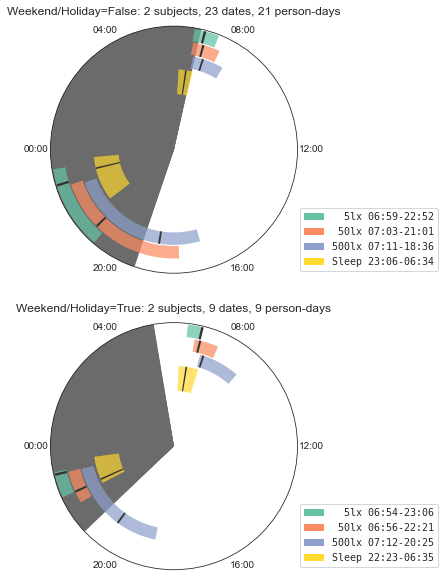

In [ ]:
ClockPlot.plot(data,
               'Weekend/Holiday',
               thresholds = [5, 50, 500],
               timezone = 'America/Los_Angeles')

In [ ]:
#export
class LightPlot:
    """Creates various light plots for grouped data based on time of day."""
    
    @staticmethod
    def plot(data_list, labels, palette = "deep",
                plot_type= "mean/sem", y_lim = None):
        """Generates light plots.
        
        #### Parameters
    
        data_list: list

            A list of series of light data for plotting.
        labels: list

            A list of labels corresponding how you'd like each series in d_list to be labeled.
        palette: string

            Valid seaborn color palette title. 
        plot_type: str

            The type of plot you'd like to create. Default is "mean/sem". Other choices are 
            "counts", and "quantiles"
        y_limit: int or None

            Desired default range for y_limit of the outputted plots.
        """
        
        if len(data_list) != len(labels):
            raise ValueError("Number of data series must match number of labels.")
        d_m = []
        d_low = []
        d_high = []
        tinc = 200
        y_label = "Lux"
        
        if plot_type == "mean/sem":
            for data in data_list:
                d_m.append(pd.Series(data.mean()).sort_index())
                # sem = standard error
                tmp = pd.Series(data.sem()).sort_index()
                d_low.append(d_m[-1] - tmp)
                d_high.append(d_m[-1] + tmp)
                
        elif plot_type == "counts":
            tinc = 5000
            y_label = "Number of Samples"
            func = lambda x: x.max().to_frame().shape[0]
            y_choices = [func(x) for x in data_list]
            y_lim = np.max(y_choices) * 10
            for data in data_list:
                d_m.append(data.count().sort_index())
                d_low.append(d_m[-1])
                d_high.append(d_m[-1])
        elif plot_type == "quantiles":
            for data in data_list:
                d_m.append(data.median().sort_index())
                d_low.append(data.quantile(0.25).sort_index())
                d_high.append(data.quantile(0.75).sort_index())
        else:
            raise ValueError("Valid plot choices are 'mean/sem', 'counts', 'quantiles'.")
        
        plt.figure(figsize=(8,6))
        ax=plt.gca()
        palette = sns.color_palette(palette)
        palette_idx = 0
        
        for mid, lo, hi, lab in zip(d_m,d_low,d_high,labels):
            cval = mpl.colors.to_hex(palette[palette_idx])
            palette_idx = palette_idx + 1
            timval = [pd.Timestamp(av.isoformat()) for av in mid.index.tolist()]

            vals = pd.DataFrame(mid)
            vals['time']=vals.index.to_series()
            vals['mins']=vals.time.apply(lambda x: x.second / 60.0 + x.minute + x.hour * 60.0)
            vals['lux-mins']=vals['White Light']*vals['mins']
            v = vals['lux-mins'].dropna().mean()/vals['White Light'].dropna().mean()
            hrs = int(v / 1440*24)
            mins = int((v - hrs * 60))
            tmid = time(hrs, mins)
            print ('{} - cumulative {}*sec: {:e}, center of mass of light exposure: {}'.format(lab                     ,y_label.strip(),mid.sum()*20,tmid))
            lab = lab+'\n{:4.3e} lx*s, COLE {}'.format(mid.sum()*20,tmid)

            ax.plot(timval, mid.values, color=cval, label=lab)
            ax.fill_between(timval, hi.values, lo.values, color=cval, alpha=0.33)
        
        ax.legend()

        # format the ticks
        tFmt = md.DateFormatter('%H:%M')
        ax.xaxis.set_major_locator(md.HourLocator(byhour=range(0,24,4)))
        ax.xaxis.set_major_formatter(tFmt)
        if y_lim is not None:
            ax.set_ylim(0,y_lim)
        ax.yaxis.set_ticks(np.arange(tinc,y_lim,tinc))

        ax.grid(True)
        plt.ylabel(y_label + " " + plot_type)
        plt.xlabel('Time of day')

In [ ]:
show_doc(LightPlot.plot, title_level = 3)

<h3 id="LightPlot.plot" class="doc_header"><code>LightPlot.plot</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h3>

> <code>LightPlot.plot</code>(**`data_list`**, **`labels`**, **`palette`**=*`'deep'`*, **`plot_type`**=*`'mean/sem'`*, **`y_lim`**=*`2500`*)

Generates light plots.

#### Parameters

data_list: list

    A list of series of light data for plotting.
labels: list

    A list of labels corresponding how you'd like each series in d_list to be labeled.
palette: string

    Valid seaborn color palette title. 
plot_type: str

    The type of plot you'd like to create. Default is "mean/sem". Other choices are 
    "counts", and "quantiles"
y_limit: int

    Desired default range for y_limit of the outputted plots.

## Creating Light Plots

The other core plot type for SALA are specialized light plots. The y-axis size can be controlled for mean/sem plots or quantile plots. There are three available light plot styles:

* "mean/sem"

Plots the mean and standard error for light measurement across a day.

* counts

Plots the counts for light measurement across a day.

* quantiles

Plots quantiles of light measuurement across a day. 

In the following example analysis, we'll take the same example data used for the main SALA module and plot data that exists under the following conditions by grouping times to the nearest
quarter-hour:

1. The watch must be On-Wrist

2. The interval status must be either 'ACTIVE' or 'REST'

3. The White Light reading must be at least 1.0. Lower light readings tend to be less accurate, and potentially noisy.
   
Any quarter-hours with under 50 valid light readings are ommitted.

In [ ]:
def quarter_hourly(dtime):
    tm = pd.to_datetime('{}:{:02d}'.format(dtime.hour,(dtime.minute//15)*15))
    return tm.time()

In [ ]:
all_data = pd.read_parquet(file_prefix+'raw.parquet')
these_rows = np.logical_and( np.logical_not(all_data['Off-Wrist Status']), np.logical_and( all_data['Interval Status'].isin(['ACTIVE','REST']), all_data['White Light']>1.0) ) 
for agroup in all_data.Group.unique():
    print(agroup)
    theones = (all_data.Group == agroup) & (these_rows)
    exec('{} = all_data[theones].dropna().groupby(quarter_hourly).filter(lambda x: x["White Light"].count()>50,dropna=False).groupby(quarter_hourly)'.format(agroup.replace(' ','_'),  ))

base_
follow_up_


By going through the raw data, we've generated two dataframes for light that can be compared.

In [ ]:
sns.set(style = "darkgrid")

This first example plot compares mean white light from the existing raw data by separating it based on the corresponding visit (base or follow up). The shadows drawn are corresponding standard error measurements.

base_ - cumulative Lux*sec: 1.110292e+06, center of mass of light exposure: 13:35:00
follow_up_ - cumulative Lux*sec: 1.258620e+06, center of mass of light exposure: 12:45:00


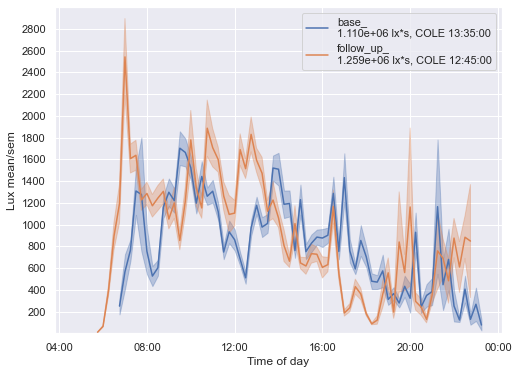

In [ ]:
LightPlot.plot([base_["White Light"],
                follow_up_["White Light"]],
               ["base_", "follow_up_"],
              y_lim = 3000)

This second example plot compares the mean number of samples across the day for each of the visit types. 

base_ - cumulative Number of Samples*sec: 3.976200e+05, center of mass of light exposure: 13:58:00
follow_up_ - cumulative Number of Samples*sec: 3.824600e+05, center of mass of light exposure: 13:31:00


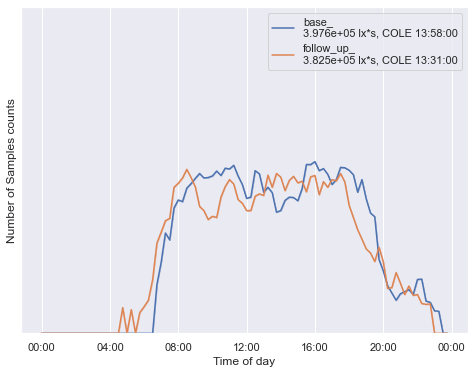

In [ ]:
LightPlot.plot([base_["White Light"],
                follow_up_["White Light"]],
               ["base_", "follow_up_"],
               plot_type = "counts")

The final plot shows quantiles of light compared for the two visit types.

base_ - cumulative Lux*sec: 2.590423e+05, center of mass of light exposure: 13:09:00
follow_up_ - cumulative Lux*sec: 3.524821e+05, center of mass of light exposure: 12:00:00


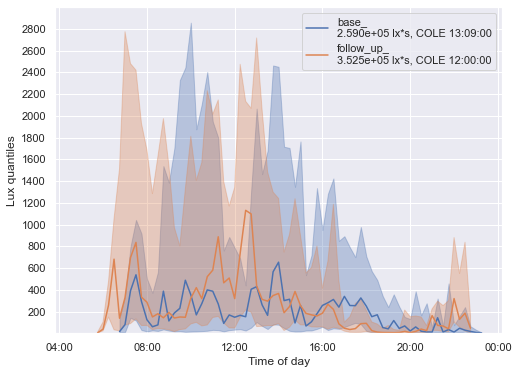

In [ ]:
LightPlot.plot([base_["White Light"],
                follow_up_["White Light"]],
               ["base_", "follow_up_"],
               plot_type = "quantiles", y_lim = 3000)